Система интеллектуального подбора кандидатов
Платформа Iconicompany

[1/5] Инициализация системы подбора...
Загрузка модели nomic-ai/nomic-embed-text-v1.5...


<All keys matched successfully>



[2/5] Загрузка данных...
✓ Загружено резюме 1
✓ Загружено резюме 10
✓ Загружено резюме 11
✓ Загружено резюме 13
✓ Загружено резюме 14
✓ Загружено резюме 15
✓ Загружено резюме 16
✓ Загружено резюме 17
✓ Загружено резюме 18
✓ Загружено резюме 19
✓ Загружено резюме 2
✓ Загружено резюме 20
✓ Загружено резюме 21
✓ Загружено резюме 22
✓ Загружено резюме 23
✓ Загружено резюме 24
✓ Загружено резюме 25
✓ Загружено резюме 26
✓ Загружено резюме 27
✓ Загружено резюме 28
✓ Загружено резюме 29
✓ Загружено резюме 3
✓ Загружено резюме 30
✓ Загружено резюме 31
✓ Загружено резюме 32
✓ Загружено резюме 33
✓ Загружено резюме 34
✓ Загружено резюме 35
✓ Загружено резюме 36
✓ Загружено резюме 37
✓ Загружено резюме 38
✓ Загружено резюме 39
✓ Загружено резюме 4
✓ Загружено резюме 40
✓ Загружено резюме 41
✓ Загружено резюме 42
✓ Загружено резюме 43
✓ Загружено резюме 44
✓ Загружено резюме 45
✓ Загружено резюме 46
✓ Загружено резюме 47
✓ Загружено резюме 48
✓ Загружено резюме 49
✓ Загружено резюме 5
✓ Загружено

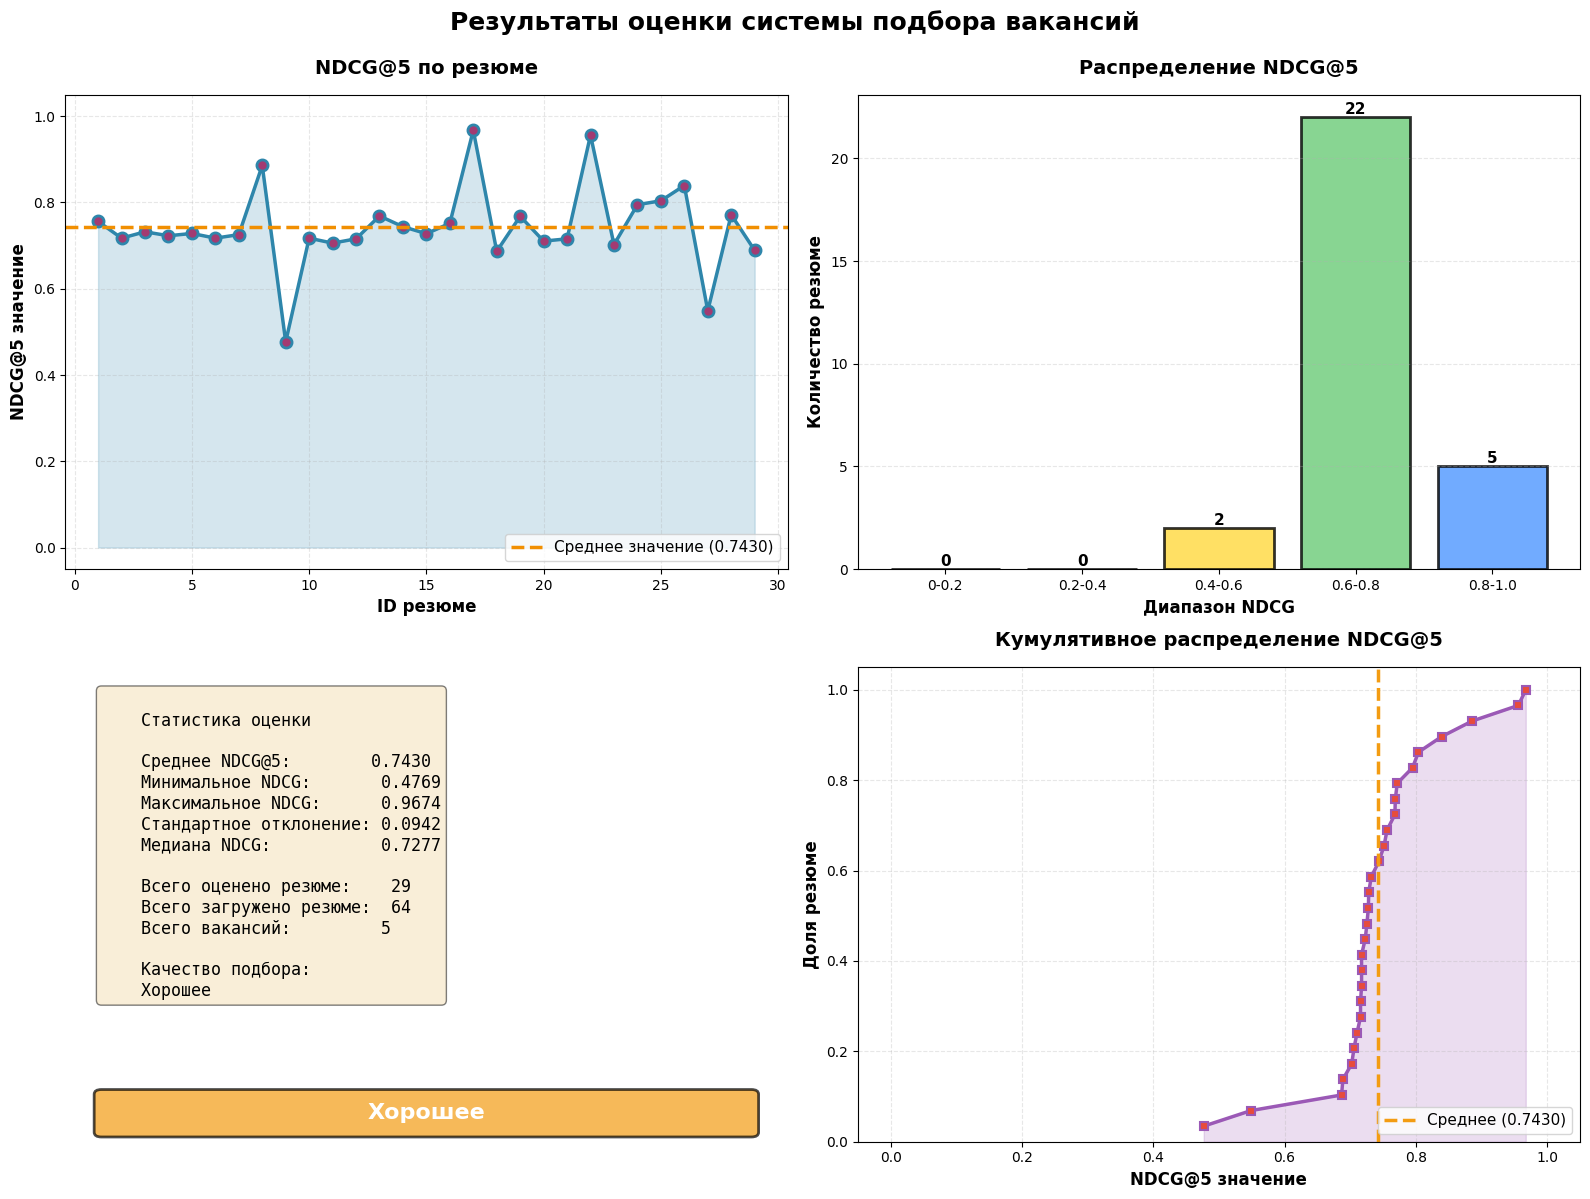


Обработка завершена успешно!


In [2]:
import os
import csv
import re
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
from collections import defaultdict

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

class VacancyResumeMatcher:
    """
    Система для матчинга резюме с вакансиями
    Использует векторный поиск через nomic-embed-text и комбинированный скоринг
    """

    def __init__(self, model_name: str = "nomic-ai/nomic-embed-text-v1.5"):
        """
        Инициализация модели эмбеддингов
        """
        print(f"Загрузка модели {model_name}...")
        self.model = SentenceTransformer(model_name, trust_remote_code=True)
        self.scaler = MinMaxScaler()

    def extract_text_from_docx(self, filepath: str) -> str:
        """
        Извлечение текста из DOCX файла
        """
        try:
            from docx import Document
            doc = Document(filepath)
            text = "\n".join([para.text for para in doc.paragraphs])
            return text
        except Exception as e:
            print(f"Ошибка при чтении {filepath}: {e}")
            return ""

    def load_resumes(self, cv_folder: str) -> Dict[int, str]:
        """
        Загрузка всех резюме из папки CV
        """
        resumes = {}
        cv_path = Path(cv_folder)

        for docx_file in sorted(cv_path.glob("*.docx")):
            try:
                cv_id = int(docx_file.stem)
                text = self.extract_text_from_docx(str(docx_file))
                if text.strip():
                    resumes[cv_id] = text
                    print(f"✓ Загружено резюме {cv_id}")
            except ValueError:
                continue

        print(f"\nВсего загружено резюме: {len(resumes)}")
        return resumes

    def load_vacancies(self, csv_path: str) -> Dict[int, Dict]:
        """
        Загрузка вакансий из CSV файла
        """
        vacancies = {}

        with open(csv_path, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                vacancy_id = int(row['id'])
                vacancies[vacancy_id] = {
                    'title': row['job_title'],
                    'description': row['job_description'],
                    'uid': row['uid']
                }

        print(f"Загружено вакансий: {len(vacancies)}")
        return vacancies

    def extract_key_terms(self, text: str) -> List[str]:
        """
        Извлечение ключевых терминов из текста
        """
        skill_patterns = [
            r'\b(python|java|c\+\+|c#|javascript|typescript|php|ruby|go|rust|kotlin)\b',
            r'\b(sql|mysql|postgresql|oracle|mongodb|elasticsearch|redis)\b',
            r'\b(react|angular|vue|django|flask|spring|asp\.net|express)\b',
            r'\b(aws|azure|gcp|kubernetes|docker|jenkins|gitlab)\b',
            r'\b(git|svn|tfs|mercurial)\b',
            r'\b(agile|scrum|kanban|devops|ci/cd)\b',
            r'\b(rest|api|graphql|soap|microservices)\b',
            r'\b(linux|unix|windows|macos)\b',
            r'\b(html|css|xml|json|yaml)\b',
            r'\b(testing|unit test|integration test|qa|qc)\b',
        ]

        terms = []
        text_lower = text.lower()

        for pattern in skill_patterns:
            matches = re.finditer(pattern, text_lower)
            for match in matches:
                term = match.group(1)
                if term not in terms:
                    terms.append(term)

        return terms

    def calculate_skill_overlap(self, vacancy_text: str, resume_text: str) -> float:
        """
        Расчёт перекрытия навыков между вакансией и резюме (0-1)
        """
        vacancy_skills = set(self.extract_key_terms(vacancy_text))
        resume_skills = set(self.extract_key_terms(resume_text))

        if not vacancy_skills:
            return 0.5

        overlap = len(vacancy_skills.intersection(resume_skills))
        jaccard_similarity = overlap / len(vacancy_skills.union(resume_skills))

        return jaccard_similarity

    def calculate_text_length_match(self, vacancy_text: str, resume_text: str) -> float:
        """
        Метрика соответствия по длине текстов
        """
        vacancy_length = len(vacancy_text.split())
        resume_length = len(resume_text.split())

        if resume_length < vacancy_length * 0.3:
            return 0.5
        elif resume_length > vacancy_length * 2:
            return 0.7
        else:
            return 1.0

    def encode_texts(self, texts: List[str]) -> np.ndarray:
        """
        Кодирование текстов в векторы с помощью модели эмбеддингов
        """
        embeddings = self.model.encode(texts, normalize_embeddings=True, show_progress_bar=False)
        return embeddings

    def rank_vacancies_for_resume(self, resume_id: int, resume_text: str,
                                   vacancies: Dict[int, Dict],
                                   vacancy_embeddings: Dict[int, np.ndarray],
                                   resume_embedding: np.ndarray) -> List[Tuple[int, float]]:
        """
        Ранжирование вакансий для конкретного резюме
        """
        scores = []

        for vacancy_id, vacancy in vacancies.items():
            vacancy_text = vacancy['description']
            vacancy_embedding = vacancy_embeddings[vacancy_id]

            # 1. Косинусное сходство
            cosine_sim = cosine_similarity(
                [resume_embedding],
                [vacancy_embedding]
            )[0][0]

            # 2. Перекрытие навыков
            skill_overlap = self.calculate_skill_overlap(vacancy_text, resume_text)

            # 3. Соответствие по длине
            length_match = self.calculate_text_length_match(vacancy_text, resume_text)

            # Комбинированный скор
            combined_score = (
                0.60 * cosine_sim +
                0.25 * skill_overlap +
                0.15 * length_match
            )

            scores.append((vacancy_id, combined_score))

        # Сортировка по убыванию скора
        scores.sort(key=lambda x: x[1], reverse=True)

        return scores

    def calculate_ndcg(self, predicted_ranking: List[int],
                  ground_truth_ranking: List[int], k: int = 5) -> float:
        """
        Расчёт NDCG@k с учётом ПОРЯДКА ground truth
        """
        if not ground_truth_ranking or len(ground_truth_ranking) == 0:
            return 0.0

        # Создаём маппирование: вакансия → её идеальная позиция (релевантность)
        gt_positions = {vacancy_id: idx for idx, vacancy_id in enumerate(ground_truth_ranking)}

        # DCG - суммируем релевантность по позициям предсказания
        dcg = 0.0
        for i, vacancy_id in enumerate(predicted_ranking[:k]):
            if vacancy_id in gt_positions:
                # Релевантность = 1/(позиция в GT + 1)
                # Вакансия на позиции 0 в GT получает вес 1
                # Вакансия на позиции 1 в GT получает вес 1/2 и т.д.
                relevance = 1.0 / (gt_positions[vacancy_id] + 1)
                dcg += relevance / np.log2(i + 2)

        # IDCG - идеальный случай: все вакансии на своих позициях
        idcg = 0.0
        for i in range(min(k, len(gt_positions))):
            relevance = 1.0 / (i + 1)
            idcg += relevance / np.log2(i + 2)

        if idcg == 0:
            return 0.0

        ndcg = dcg / idcg
        return ndcg

    def evaluate_on_ground_truth(self, predictions: Dict[int, List[Tuple[int, float]]],
                                ground_truth: Dict[int, List[int]],
                                k: int = 5) -> Dict:
        """
        Оценка качества предсказаний с использованием ground truth аннотаций
        """
        ndcg_scores = []
        evaluated_count = 0

        for cv_id in sorted(predictions.keys()):
            if cv_id not in ground_truth:
                print(f"⚠ Резюме {cv_id}: нет ground truth")
                continue

            # Получаем ID вакансий из предсказаний (ранжированные)
            predicted_vacancy_ids = [pred[0] for pred in predictions[cv_id]]
            ground_truth_ranking = ground_truth[cv_id]

            # Проверим ground truth
            if not ground_truth_ranking or len(ground_truth_ranking) == 0:
                print(f"⚠ Резюме {cv_id}: пустой ground truth")
                continue

            # Рассчитываем NDCG
            ndcg = self.calculate_ndcg(predicted_vacancy_ids, ground_truth_ranking, k=k)
            ndcg_scores.append(ndcg)
            evaluated_count += 1

            if cv_id <= 5:
                print(f"  CV #{cv_id}: NDCG@{k}={ndcg:.4f}, GT={ground_truth_ranking}, Pred top 3={predicted_vacancy_ids[:3]}")

        avg_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0

        return {
            'avg_ndcg@5': avg_ndcg,
            'ndcg_scores': ndcg_scores,
            'count_evaluated': evaluated_count
        }


class AIAssistant:
    """
    ИИ-ассистент для HR-специалистов
    """

    def __init__(self, matcher: VacancyResumeMatcher):
        self.matcher = matcher

    def generate_report(self, resume_id: int, resume_text: str,
                       ranked_vacancies: List[Tuple[int, float]],
                       vacancies: Dict[int, Dict], top_n: int = 3) -> str:
        """
        Генерирует отчёт с рекомендуемыми вакансиями для резюме
        """
        report = f"""
╔════════════════════════════════════════════════════════════════╗
║              Рекомендуемые вакансии для резюме #{resume_id}        ║
╚════════════════════════════════════════════════════════════════╝

Топ-{top_n} рекомендуемых вакансий:
"""

        for i, (vacancy_id, score) in enumerate(ranked_vacancies[:top_n], 1):
            if vacancy_id not in vacancies:
                continue

            vacancy = vacancies[vacancy_id]
            skills = self.matcher.extract_key_terms(resume_text)
            skill_overlap = self.matcher.calculate_skill_overlap(vacancy['description'], resume_text)
            confidence = int(score * 100)

            report += f"""
{i}. Вакансия #{vacancy_id}: {vacancy['title']}
   ├─ Уверенность подбора: {confidence}%
   ├─ Перекрытие навыков: {int(skill_overlap * 100)}%
   ├─ Основные навыки кандидата: {', '.join(skills[:5]) if skills else 'Не определены'}
   └─ Рекомендация: {'Высокий приоритет' if confidence >= 75 else '✓ Средний приоритет' if confidence >= 50 else 'Низкий приоритет'}
"""

        report += "\n╚════════════════════════════════════════════════════════════════╝\n"
        return report


def load_ground_truth():
    """
    Загрузка экспертных аннотаций
    Маппирует позиции вакансий (1-5) на реальные ID из CSV
    """
    # Маппирование позиций на реальные ID вакансий из CSV
    VACANCY_ID_MAP = {
        1: 8,      # Позиция 1 → ID 8
        2: 37,     # Позиция 2 → ID 37
        3: 90,     # Позиция 3 → ID 90
        4: 207,    # Позиция 4 → ID 207
        5: 499     # Позиция 5 → ID 499
    }

    ground_truth = {}

    # Аннотации от HR специалиста (позиции 1-5)
    annotator_1_positions = [
        [2, 1, 4, 3, 5],  # CV 1
        [1, 2, 3, 4, 5],  # CV 2
        [1, 2, 3, 4, 5],  # CV 3
        [3, 1, 2, 4, 5],  # CV 4
        [1, 5, 4, 2, 3],  # CV 5
        [3, 2, 1, 4, 5],  # CV 6
        [3, 2, 1, 5, 4],  # CV 7
        [2, 4, 3, 1, 5],  # CV 8
        [1, 5, 2, 1, 4],  # CV 9 (note: has error - two 1s, ignoring)
        [3, 2, 1, 4, 5],  # CV 10
        [1, 2, 3, 4, 5],  # CV 11
        [1, 2, 3, 4, 5],  # CV 12
        [1, 3, 2, 4, 5],  # CV 13
        [1, 2, 3, 4, 5],  # CV 14
        [3, 1, 2, 4, 5],  # CV 15
        [3, 1, 2, 4, 5],  # CV 16
        [3, 1, 2, 4, 5],  # CV 17
        [1, 2, 5, 3, 4],  # CV 18
        [3, 2, 1, 4, 5],  # CV 19
        [3, 2, 1, 4, 5],  # CV 20
        [2, 3, 1, 4, 5],  # CV 21
        [1, 2, 3, 5, 4],  # CV 22
        [2, 1, 3, 5, 4],  # CV 23
        [1, 2, 3, 5, 4],  # CV 24
        [1, 2, 3, 4, 5],  # CV 25
        [2, 1, 3, 4, 5],  # CV 26
        [2, 3, 4, 5, 1],  # CV 27
        [2, 4, 3, 2, 5],  # CV 28 (note: has error - two 2s)
        [5, 1, 2, 4, 3],  # CV 29
        [2, 1, 4, 3, 5]   # CV 30
    ]

    # Преобразуем позиции в реальные ID вакансий
    for cv_id, positions in enumerate(annotator_1_positions, start=1):
        # Маппируем каждую позицию на реальный ID
        real_ids = [VACANCY_ID_MAP[pos] for pos in positions]
        ground_truth[cv_id] = real_ids

    return ground_truth


def main():
    """
    Главная функция для запуска полного пайплайна
    """
    print("=" * 70)
    print("Система интеллектуального подбора кандидатов")
    print("Платформа Iconicompany")
    print("=" * 70)

    CV_FOLDER = "./CV"
    VACANCIES_CSV = "./5_vacancies.csv"

    if not os.path.exists(CV_FOLDER):
        print(f"Ошибка: Папка '{CV_FOLDER}' не найдена")
        return

    if not os.path.exists(VACANCIES_CSV):
        print(f"Ошибка: Файл '{VACANCIES_CSV}' не найден")
        return

    print("\n[1/5] Инициализация системы подбора...")
    matcher = VacancyResumeMatcher()

    print("\n[2/5] Загрузка данных...")
    resumes = matcher.load_resumes(CV_FOLDER)
    vacancies = matcher.load_vacancies(VACANCIES_CSV)
    ground_truth = load_ground_truth()

    if not resumes:
        print("Не удалось загрузить резюме")
        return

    print(f"\n[3/5] Кодирование текстов в векторы...")
    print(f"Будет закодировано: {len(resumes)} резюме + {len(vacancies)} вакансий")

    # Кодируем все тексты сразу (эффективнее)
    all_resume_texts = [resumes[rid] for rid in sorted(resumes.keys())]
    all_vacancy_texts = [vacancies[vid]['description'] for vid in sorted(vacancies.keys())]

    resume_ids = sorted(resumes.keys())
    vacancy_ids = sorted(vacancies.keys())

    print("\nКодирование резюме...")
    resume_embeddings_list = matcher.encode_texts(all_resume_texts)
    resume_embeddings = {rid: resume_embeddings_list[i] for i, rid in enumerate(resume_ids)}

    print("Кодирование вакансий...")
    vacancy_embeddings_list = matcher.encode_texts(all_vacancy_texts)
    vacancy_embeddings = {vid: vacancy_embeddings_list[i] for i, vid in enumerate(vacancy_ids)}

    print("\n[4/5] Ранжирование вакансий для резюме...")
    all_predictions = {}

    for cv_id in sorted(resumes.keys())[:30]:  # Оцениваем только первые 30
        resume_text = resumes[cv_id]
        resume_embedding = resume_embeddings[cv_id]

        # Ранжируем вакансии для этого резюме
        ranked = matcher.rank_vacancies_for_resume(
            cv_id, resume_text, vacancies,
            vacancy_embeddings, resume_embedding
        )

        all_predictions[cv_id] = ranked

    print("\n[5/5] Оценка качества подбора...")
    evaluation = matcher.evaluate_on_ground_truth(all_predictions, ground_truth, k=5)

    print("\n" + "=" * 70)
    print("Результаты оценки")
    print("=" * 70)
    print(f"Средний NDCG@5: {evaluation['avg_ndcg@5']:.4f}")
    print(f"Оценено резюме: {evaluation['count_evaluated']}")
    print(f"Детали NDCG по каждому резюме:")

    for i, ndcg in enumerate(evaluation['ndcg_scores'][:10], 1):
        print(f"   CV #{i}: {ndcg:.4f}")

    if len(evaluation['ndcg_scores']) > 10:
        print(f"   ... и ещё {len(evaluation['ndcg_scores']) - 10} резюме")

    print("\n" + "=" * 70)
    print("Демонстрация ИИ-ассистента")
    print("=" * 70)

    assistant = AIAssistant(matcher)

    # Пример для первого резюме
    demo_resume_id = 1
    demo_resume_text = resumes[demo_resume_id]
    ranked_for_demo = all_predictions.get(demo_resume_id, [])

    if ranked_for_demo:
        report = assistant.generate_report(
            demo_resume_id,
            demo_resume_text,
            ranked_for_demo,
            vacancies,
            top_n=3
        )
        print(report)


        print("\n" + "=" * 70)
    print("Создание визуализации результатов")
    print("=" * 70)

    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib import rcParams

    rcParams['font.sans-serif'] = ['DejaVu Sans']
    rcParams['axes.unicode_minus'] = False

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Результаты оценки системы подбора вакансий', fontsize=18, fontweight='bold', y=0.995)

    ndcg_scores = evaluation['ndcg_scores']
    avg_ndcg = evaluation['avg_ndcg@5']

    cv_numbers = list(range(1, len(ndcg_scores) + 1))

    # График 1: NDCG по резюме (линейный график)
    axes[0, 0].plot(cv_numbers, ndcg_scores, marker='o', linestyle='-', linewidth=2.5,
                    markersize=8, color='#2E86AB', markerfacecolor='#A23B72', markeredgewidth=2)
    axes[0, 0].axhline(y=avg_ndcg, color='#F18F01', linestyle='--', linewidth=2.5,
                       label=f'Среднее значение ({avg_ndcg:.4f})')
    axes[0, 0].fill_between(cv_numbers, ndcg_scores, alpha=0.2, color='#2E86AB')
    axes[0, 0].set_title('NDCG@5 по резюме', fontsize=14, fontweight='bold', pad=15)
    axes[0, 0].set_xlabel('ID резюме', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('NDCG@5 значение', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=11, loc='lower right')
    axes[0, 0].grid(True, alpha=0.3, linestyle='--')
    axes[0, 0].set_ylim(-0.05, 1.05)

    # График 2: Распределение NDCG (гистограмма)
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    counts, _ = np.histogram(ndcg_scores, bins=bins)
    colors_hist = ['#FF6B6B', '#FFA500', '#FFD93D', '#6BCB77', '#4D96FF']
    bars = axes[0, 1].bar(['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0'], counts,
                          color=colors_hist, edgecolor='black', linewidth=2, alpha=0.8)
    axes[0, 1].set_title('Распределение NDCG@5', fontsize=14, fontweight='bold', pad=15)
    axes[0, 1].set_xlabel('Диапазон NDCG', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Количество резюме', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

    for bar in bars:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # График 3: Статистика метрик
    axes[1, 0].axis('off')

    stats_text = f"""
    Статистика оценки

    Среднее NDCG@5:        {avg_ndcg:.4f}
    Минимальное NDCG:       {min(ndcg_scores):.4f}
    Максимальное NDCG:      {max(ndcg_scores):.4f}
    Стандартное отклонение: {np.std(ndcg_scores):.4f}
    Медиана NDCG:           {np.median(ndcg_scores):.4f}

    Всего оценено резюме:    {evaluation['count_evaluated']}
    Всего загружено резюме:  {len(resumes)}
    Всего вакансий:         {len(vacancies)}

    Качество подбора:
    """

    if avg_ndcg >= 0.8:
        quality = "Отличное"
        color = "#2ECC71"
    elif avg_ndcg >= 0.6:
        quality = "Хорошее"
        color = "#F39C12"
    elif avg_ndcg >= 0.4:
        quality = "Среднее"
        color = "#E74C3C"
    else:
        quality = "Требует улучшения"
        color = "#C0392B"

    stats_text += quality

    axes[1, 0].text(0.05, 0.95, stats_text, transform=axes[1, 0].transAxes,
                   fontsize=12, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    quality_box = mpatches.FancyBboxPatch((0.05, 0.02), 0.9, 0.08,
                                         transform=axes[1, 0].transAxes,
                                         boxstyle="round,pad=0.01",
                                         facecolor=color, edgecolor='black',
                                         linewidth=2, alpha=0.7)
    axes[1, 0].add_patch(quality_box)
    axes[1, 0].text(0.5, 0.06, quality, transform=axes[1, 0].transAxes,
                   fontsize=16, fontweight='bold', ha='center', va='center', color='white')

    # График 4: Кумулятивное распределение
    sorted_ndcg = sorted(ndcg_scores)
    cumulative = np.arange(1, len(sorted_ndcg) + 1) / len(sorted_ndcg)

    axes[1, 1].plot(sorted_ndcg, cumulative, marker='s', linestyle='-', linewidth=2.5,
                   markersize=6, color='#9B59B6', markerfacecolor='#E74C3C', markeredgewidth=1.5)
    axes[1, 1].axvline(x=avg_ndcg, color='#F39C12', linestyle='--', linewidth=2.5,
                      label=f'Среднее ({avg_ndcg:.4f})')
    axes[1, 1].fill_between(sorted_ndcg, cumulative, alpha=0.2, color='#9B59B6')
    axes[1, 1].set_title('Кумулятивное распределение NDCG@5', fontsize=14, fontweight='bold', pad=15)
    axes[1, 1].set_xlabel('NDCG@5 значение', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Доля резюме', fontsize=12, fontweight='bold')
    axes[1, 1].legend(fontsize=11, loc='lower right')
    axes[1, 1].grid(True, alpha=0.3, linestyle='--')
    axes[1, 1].set_xlim(-0.05, 1.05)
    axes[1, 1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
    print("\nГрафик сохранён в 'evaluation_results.png'")
    plt.show()

    print("\n" + "=" * 70)
    print("Обработка завершена успешно!")
    print("=" * 70)


if __name__ == "__main__":
    main()